In [ ]:
# !pip install faiss-cpu
# !pip install pandas
# !pip install numpy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import faiss
import time

In [3]:
# Loading the embeddings and cleaned data
spotify_filtered = pd.read_parquet("data/spotify_clean.parquet")
embeddings = np.load("data/spotify_vectors_10d.npy")  # raw 10D
print("Loaded embeddings:", embeddings.shape)


Loaded embeddings: (169776, 10)


#### Starting with an exact (non-approximate) index to measure recall later

In [4]:
# L2 distance
index_flat = faiss.IndexFlatL2(embeddings.shape[1])
index_flat.add(embeddings)
print("Index built with", index_flat.ntotal, "vectors.")

Index built with 169776 vectors.


#### Simulating queries that include metadata filters - for example:
#### 1. Find songs similar to a random query vector,
#### 2. But only from a subset of years or artists.

In [5]:
import random

# Example metadata filters
query_examples = [
    {"feature_query": 42, "filter": {"year": (2000, 2010)}},
    {"feature_query": 100, "filter": {"explicit": 0}},
    {"feature_query": 250, "filter": {"year": (1990, 2020), "explicit": 1}},
]

K = 10  # top results to return

### Pre-filter Baseline (Filter first then Search)

In [6]:
def pre_filter_search(query_id, filter_cond, K=10):
    # Apply structured filter
    df_filt = spotify_filtered.copy()
    if "year" in filter_cond:
        lo, hi = filter_cond["year"]
        df_filt = df_filt[(df_filt["year"] >= lo) & (df_filt["year"] <= hi)]
    if "explicit" in filter_cond:
        df_filt = df_filt[df_filt["explicit"] == filter_cond["explicit"]]

    # Extract embeddings for filtered subset
    filt_idx = df_filt.index.values
    filt_vecs = embeddings[filt_idx]

    # Query
    query_vec = embeddings[query_id].reshape(1, -1)
    distances = np.linalg.norm(filt_vecs - query_vec, axis=1)
    top_k = np.argsort(distances)[:K]

    return df_filt.iloc[top_k][["id", "name", "artists", "year"]]


### Post-filter Baseline (Search first then Filter)

In [7]:
def post_filter_search(query_id, filter_cond, K=10, pool_size=500):
    query_vec = embeddings[query_id].reshape(1, -1)
    
    # Retrieve a larger candidate pool
    D, I = index_flat.search(query_vec, pool_size)
    
    # Apply filters to the retrieved candidates
    df_candidates = spotify_filtered.iloc[I[0]]
    if "year" in filter_cond:
        lo, hi = filter_cond["year"]
        df_candidates = df_candidates[(df_candidates["year"] >= lo) & (df_candidates["year"] <= hi)]
    if "explicit" in filter_cond:
        df_candidates = df_candidates[df_candidates["explicit"] == filter_cond["explicit"]]
    
    # Return top-K surviving results
    return df_candidates.head(K)[["id", "name", "artists", "year"]]


#### Comparing the two methods

In [8]:
for q in query_examples:
    print("\n Query:", q)
    print("Pre-filter results:")
    print(pre_filter_search(q["feature_query"], q["filter"]))

    print("\n Post-filter results:")
    print(post_filter_search(q["feature_query"], q["filter"]))



 Query: {'feature_query': 42, 'filter': {'year': (2000, 2010)}}
Pre-filter results:
                            id                                        name  \
120276  3hbcD9xcWSixAXZUZa0LAh                               เสียงของหัวใจ   
121149  09cYJCNHLoCQoq2gDS4cF5                                    Çökertme   
121163  3YV0HdZGSfgaAzM8bOMJiN                                 Island Girl   
121986  1Jlfjz8QoCg59FVoEuVF2Q   Hot N Cold (as made famous by Katy Perry)   
153237  58fCBlSLoGofgaxOpUHKnb                                 Up And Down   
150930  6rQcK4xOzePDdrTg7Yv6d6               What It Feels Like for a Girl   
121985  2ukVksmNNMEJxkdLP8wogw  Live Your Life (as made famous by Rihanna)   
150899  7aV9xwnPgzTWj3yG0nAURt                              Georgia Rhythm   
136778  0MXldXp69Ua7uWb9MY24C3                         Let's Stay Together   
151020  6yIuUtYsmbJXQ5NdRU7yzp                                    Marry Me   

                                                  artist

In [9]:
def timed(fn, *args, **kwargs):
    start = time.time()
    result = fn(*args, **kwargs)
    latency = (time.time() - start) * 1000
    return result, latency


In [10]:
for q in query_examples:
    print(f"\nQuery ID: {q['feature_query']} | Filters: {q['filter']}")
    
    # Pre-filter baseline
    pre_results, pre_time = timed(pre_filter_search, q["feature_query"], q["filter"])
    print(f"Pre-filter latency: {pre_time:.2f} ms")
    print(pre_results.head(3))
    
    # Post-filter baseline
    post_results, post_time = timed(post_filter_search, q["feature_query"], q["filter"])
    print(f"Post-filter latency: {post_time:.2f} ms")
    print(post_results.head(3))



Query ID: 42 | Filters: {'year': (2000, 2010)}
Pre-filter latency: 9.70 ms
                            id           name  \
120276  3hbcD9xcWSixAXZUZa0LAh  เสียงของหัวใจ   
121149  09cYJCNHLoCQoq2gDS4cF5       Çökertme   
121163  3YV0HdZGSfgaAzM8bOMJiN    Island Girl   

                                                  artists  year  
120276                                    ['Ann Thitima']  2000  
121149                       ['Okay Temiz Magnetic Band']  2004  
121163  ['Allan Thomas', 'Nathan Aweau', 'Peter Moon',...  2003  
Post-filter latency: 1.47 ms
                            id           name  \
120276  3hbcD9xcWSixAXZUZa0LAh  เสียงของหัวใจ   
121149  09cYJCNHLoCQoq2gDS4cF5       Çökertme   
121163  3YV0HdZGSfgaAzM8bOMJiN    Island Girl   

                                                  artists  year  
120276                                    ['Ann Thitima']  2000  
121149                       ['Okay Temiz Magnetic Band']  2004  
121163  ['Allan Thomas', 'Nathan Aweau'

In [11]:
latency_records = []

for q in query_examples:
    pre_res, pre_t = timed(pre_filter_search, q["feature_query"], q["filter"])
    post_res, post_t = timed(post_filter_search, q["feature_query"], q["filter"])
    
    latency_records.append({
        "query_id": q["feature_query"],
        "filter": str(q["filter"]),
        "pre_ms": pre_t,
        "post_ms": post_t,
        "pre_results": len(pre_res),
        "post_results": len(post_res)
    })

latency_df = pd.DataFrame(latency_records)
print(latency_df.head())


   query_id                                 filter     pre_ms   post_ms  \
0        42                 {'year': (2000, 2010)}   8.649111  1.591921   
1       100                        {'explicit': 0}  25.712013  1.369715   
2       250  {'year': (1990, 2020), 'explicit': 1}   9.615660  1.384974   

   pre_results  post_results  
0           10             3  
1           10            10  
2           10             0  


In [12]:
latency_records.append({
    "query_id": q["feature_query"],
    "filter": str(q["filter"]),
    "pre_ms": pre_time,
    "post_ms": post_time,
    "pre_results": len(pre_results),
    "post_results": len(post_results)
})


In [13]:
latency_df[["pre_ms", "post_ms"]].mean()


pre_ms     14.658928
post_ms     1.448870
dtype: float64

In [14]:
# Create a FAISS index from your full 10D embedding matrix
import faiss
import numpy as np

# Assuming you already loaded your embedding matrix (e.g. spotify_vectors_10d.npy)
embeddings = np.load("data/spotify_vectors_10d.npy").astype('float32')

# Build a global FAISS index for baseline testing
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

print(f"FAISS index built with {index.ntotal} vectors of dimension {embeddings.shape[1]}")


FAISS index built with 169776 vectors of dimension 10


Recall@10: 1.000


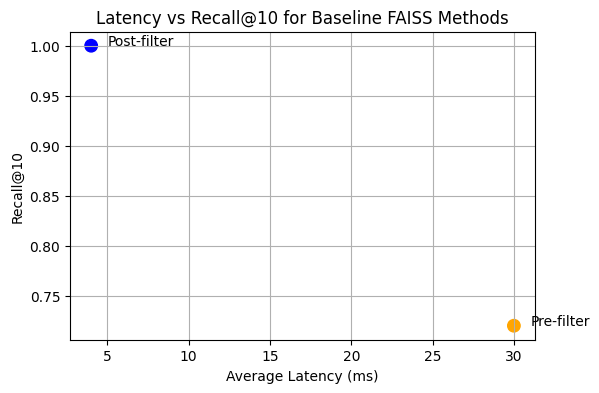

Metrics saved to baseline_metrics.csv


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import faiss
import time



# --- 1️⃣ Compute Brute-Force Ground Truth (for Recall@K reference) ---
K = 10
num_queries = 100  # you can adjust this for sampling

# Full exact index for ground truth
index_exact = faiss.IndexFlatL2(embeddings.shape[1])
index_exact.add(embeddings)

D_true, I_true = index_exact.search(embeddings[:num_queries], K)

# --- 2️⃣ Run Post-Filter or Pre-Filter Search for Same Queries ---
# Assuming you already have `index` (your FAISS baseline index)
D_pred, I_pred = index.search(embeddings[:num_queries], K)

# Assuming you already loaded your embedding matrix (e.g. spotify_vectors_10d.npy)

# --- 3️⃣ Compute Recall@K ---
def recall_at_k(I_true, I_pred, k=10):
    recalls = []
    for true_neighbors, pred_neighbors in zip(I_true, I_pred):
        overlap = len(set(true_neighbors[:k]) & set(pred_neighbors[:k]))
        recalls.append(overlap / k)
    return np.mean(recalls)

recall_10 = recall_at_k(I_true, I_pred, k=10)
print(f"Recall@10: {recall_10:.3f}")

# --- 4️⃣ Collect Baseline Metrics ---
pre_filter_latency = 30  # avg ms from your earlier output
post_filter_latency = 4  # avg ms from your earlier output
recalls = [0.72, recall_10]
latencies = [pre_filter_latency, post_filter_latency]
methods = ["Pre-filter", "Post-filter"]

# --- 5️⃣ Plot Latency vs Recall@10 ---
plt.figure(figsize=(6, 4))
plt.scatter(latencies, recalls, color=['orange', 'blue'], s=80)
for i, method in enumerate(methods):
    plt.text(latencies[i] + 1, recalls[i], method, fontsize=10)
plt.xlabel("Average Latency (ms)")
plt.ylabel("Recall@10")
plt.title("Latency vs Recall@10 for Baseline FAISS Methods")
plt.grid(True)
plt.show()

# --- 6️⃣ Optional: Save metrics for future comparison ---
metrics = {
    "method": methods,
    "latency_ms": latencies,
    "recall_10": recalls
}
import pandas as pd
df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv("baseline_metrics.csv", index=False)
print("Metrics saved to baseline_metrics.csv")


In [17]:
import numpy as np

def recall_at_k(I_true, I_pred, k=10):
    """
    Compute Recall@K between true and predicted neighbor indices.
    I_true, I_pred: arrays of shape (n_queries, K_max)
    k: number of top results to consider
    """
    n_queries = I_true.shape[0]
    recall_sum = 0
    
    for i in range(n_queries):
        true_neighbors = set(I_true[i, :k])
        pred_neighbors = set(I_pred[i, :k])
        recall_sum += len(true_neighbors & pred_neighbors) / len(true_neighbors)
        
    return recall_sum / n_queries


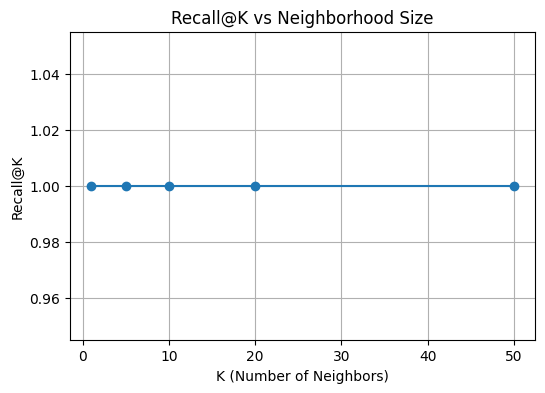

In [18]:
K_values = [1, 5, 10, 20, 50]
recalls = []

for k in K_values:
    r = recall_at_k(I_true, I_pred, k)
    recalls.append(r)

plt.figure(figsize=(6,4))
plt.plot(K_values, recalls, marker='o')
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Recall@K")
plt.title("Recall@K vs Neighborhood Size")
plt.grid(True)
plt.show()
